我们将加载必要的库。

In [3]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

接下来，我们将加载数据集。

In [32]:
california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


+ 对数据进行随机化处理,确保不会出现任何病态排序结果
+ 我们会将 median_house_value 调整为以千为单位，这样，模型就能够以常用范围内的学习速率较为轻松地学习这些数据

In [33]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe['median_house_value'] /= 1000.0
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4102,-118.0,33.9,25.0,1025.0,266.0,726.0,183.0,3.9,137.5
9633,-119.5,36.4,22.0,1824.0,333.0,1076.0,282.0,2.3,69.6
3896,-118.0,33.7,20.0,2781.0,407.0,1242.0,408.0,6.1,306.5
2122,-117.3,33.2,4.0,1837.0,287.0,934.0,277.0,3.9,189.8
5185,-118.1,33.9,33.0,3668.0,867.0,2368.0,845.0,2.9,204.9


+ 检查数据

在使用数据之前，先对它有一个初步的了解
输出关于各列的一些实用统计信息快速摘要：样本数、均值、标准偏差、最大值、最小值和各种分位数。

In [34]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


+ 构建模型

我们将尝试预测 median_house_value，它将是我们的标签（有时也称为目标）。我们将使用 total_rooms 作为输入特征。

我们将使用 TensorFlow Estimator API 提供的 LinearRegressor 接口。此 API 负责处理大量低级别模型搭建工作，并会提供执行模型训练、评估和推理的便利方法。

在 TensorFlow 中，我们使用一种称为“特征列”的结构来表示特征的数据类型。特征列仅存储对特征数据的描述；不包含特征数据本身。

一开始，我们只使用一个数值输入特征 total_rooms。以下代码会从 california_housing_dataframe 中提取 total_rooms 数据

In [35]:
my_feature = california_housing_dataframe[["total_rooms"]]
my_feature.head()

,total_rooms
4102,1025.0
9633,1824.0
3896,2781.0
2122,1837.0
5185,3668.0


使用 numeric_column 定义特征列，这样会将其数据指定为数值：

In [36]:
feature_columns = [tf.feature_column.numeric_column("total_rooms")]
feature_columns

[_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

+ 我们将定义目标

In [37]:
targets = california_housing_dataframe["median_house_value"]
targets.head()

4102   137.5
9633    69.6
3896   306.5
2122   189.8
5185   204.9
Name: median_house_value, dtype: float64

+ 配置 LinearRegressor

使用 LinearRegressor 配置线性回归模型,并使用 GradientDescentOptimizer（它会实现小批量随机梯度下降法 (SGD)）训练该模型。

为了安全起见，我们还会通过 clip_gradients_by_norm 将梯度裁剪应用到我们的优化器。梯度裁剪可确保梯度大小在训练期间不会变得过大，梯度过大会导致梯度下降法失败。

In [38]:
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer = my_optimizer
)

+ 定义输入函数

我们需要定义一个输入函数，让它告诉 TensorFlow 如何对数据进行预处理，以及在模型训练期间如何批处理、随机处理和重复数据。

首先，我们将 Pandas 特征数据转换成 NumPy 数组字典

然后，我们可以使用 TensorFlow Dataset API 根据我们的数据构建 Dataset 对象，并将数据拆分成大小为 batch_size 的多批数据，以按照指定周期数 (num_epochs) 进行重复。

**注意**：如果将默认值 num_epochs=None 传递到 repeat()，输入数据会无限期重复。

如果 shuffle 设置为 True，则我们会对数据进行随机处理，以便数据在训练期间以随机方式传递到模型。

buffer_size 参数会指定 shuffle 将从中随机抽样的数据集的大小。

最后，输入函数会为该数据集构建一个迭代器，并向 LinearRegressor 返回下一批数据。

In [39]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert Pandas data into a dict of np arrays
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset and configure batching/repeating
    ds = Dataset.from_tensor_slices((features, targets)) # warning:2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data. if specified
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

+ 训练模型

现在，我们可以在 linear_regressor 上调用 train() 来训练模型。

In [40]:
_ = linear_regressor.train(input_fn=lambda:my_input_fn(my_feature, targets), steps=100)

+ 评估模型

我们基于该训练数据做一次预测，看看我们的模型在训练期间与这些数据的拟合情况。

In [41]:
# Create an input function for predictions
# Note: Since we're making just one prediction for each example
# We don't need to repeat for shuffle the data here
prediction_input_fn = lambda:my_input_fn(my_feature, targets, num_epochs=1)

predictions = linear_regressor.predict(input_fn=prediction_input_fn)

predictions = np.array([item['predictions'][0] for item in predictions])

mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squard_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 30850.673
Root Mean Squared Error (on training data): 176.420


这是出色的模型吗？您如何判断误差有多大？

由于均方误差 (MSE) 很难解读，因此我们经常查看的是均方根误差 (RMSE)。RMSE 的一个很好的特性是，它可以在与原目标相同的规模下解读。

我们来比较一下 RMSE 与目标最大值和最小值的差值：

In [42]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()

min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 176.420


我们可以了解一下根据总体摘要统计信息，预测和目标的符合情况。

In [43]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,113.7,207.3
std,93.7,116.0
min,0.1,15.0
25%,62.9,119.4
50%,91.5,180.4
75%,135.5,265.0
max,1631.3,500.0


In [44]:
calibration_data

,predictions,targets
0,59.1,66.9
1,332.9,80.1
2,66.7,85.7
3,197.3,73.4
4,135.2,65.5
...,...,...
16995,121.6,111.4
16996,204.1,79.0
16997,57.4,103.6
16998,60.3,85.8


我们还可以将数据和学到的线可视化。我们已经知道，单个特征的线性回归可绘制成一条将输入 x 映射到输出 y 的线。

我们将获得均匀分布的随机数据样本，以便绘制可辨的散点图。

In [53]:
sample = california_housing_dataframe.sample(n=300)

然后，我们根据模型的偏差项和特征权重绘制学到的线，并绘制散点图。该线会以红色显示。

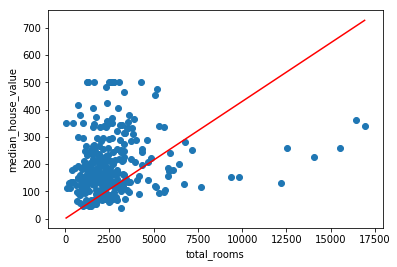

In [54]:
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

weight = linear_regressor.get_variable_value("linear/linear_model/total_rooms/weights")[0]
bias = linear_regressor.get_variable_value("linear/linear_model/bias_weights")

# 绘制模型决策线
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

plt.plot([x_0, x_1], [y_0, y_1], c='r')

plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# 绘制原始数据点
plt.scatter(sample["total_rooms"], sample["median_house_value"])
# 显示决策线和原始数据点的差距
plt.show()

 ## 调整模型超参数
对于本练习，为方便起见，我们已将上述所有代码放入一个函数中。您可以使用不同的参数调用该函数，以了解相应效果。

我们会在 10 个等分的时间段内使用此函数，以便观察模型在每个时间段的改善情况。

对于每个时间段，我们都会计算训练损失并绘制相应图表。这可以帮助您判断模型收敛的时间，或者模型是否需要更多迭代。

此外，我们还会绘制模型随着时间的推移学习的特征权重和偏差项值的曲线图。您还可以通过这种方式查看模型的收敛效果。

In [94]:
def train_model(learning_rate, steps, batch_size, periods = 10, input_feature="total_rooms"):
    # periods 控制报告力度，如果periods设为7. setps设为70， 则每训练10次输出一次损失值
    steps_per_period = steps / periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label]
    
    # Create feature columns
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda:my_input_fn(my_feature_data, targets, num_epochs=1)
    
    # Create a linear regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    # Set up to plot the state of out model's line each period
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range(0, periods):
        # Train the model, starting from the prior state
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item["predictions"][0] for item in predictions])
        
        # Compute loss
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss
        print("period %02d : %0.2f"%(period, root_mean_squared_error))
        root_mean_squared_errors.append(root_mean_squared_error)
        y_extents = np.array([0, sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value("linear/linear_model/%s/weights" %input_feature)[0]
        bias = linear_regressor.get_variable_value("linear/linear_model/bias_weights")
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents, sample[my_feature].max()), sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    print("Model training finished")
    
    # Output a graph of loss metrics over periods
    plt.subplot(1, 2, 2)
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # Output a table with calibration data
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    print("Final RMSE (on training data): %0.2f" %root_mean_squared_error)
    return calibration_data

Training model...
RMSE (on training data):
period 00 : 176.28
period 01 : 208.72
period 02 : 253.09
period 03 : 279.04
period 04 : 229.83
period 05 : 181.06
period 06 : 192.31
period 07 : 181.58
period 08 : 229.62
period 09 : 230.56
Model training finished


,predictions,targets
count,17000.0,17000.0
mean,237.9,207.3
std,196.2,116.0
min,0.2,15.0
25%,131.6,119.4
50%,191.4,180.4
75%,283.6,265.0
max,3414.2,500.0


Final RMSE (on training data): 230.56


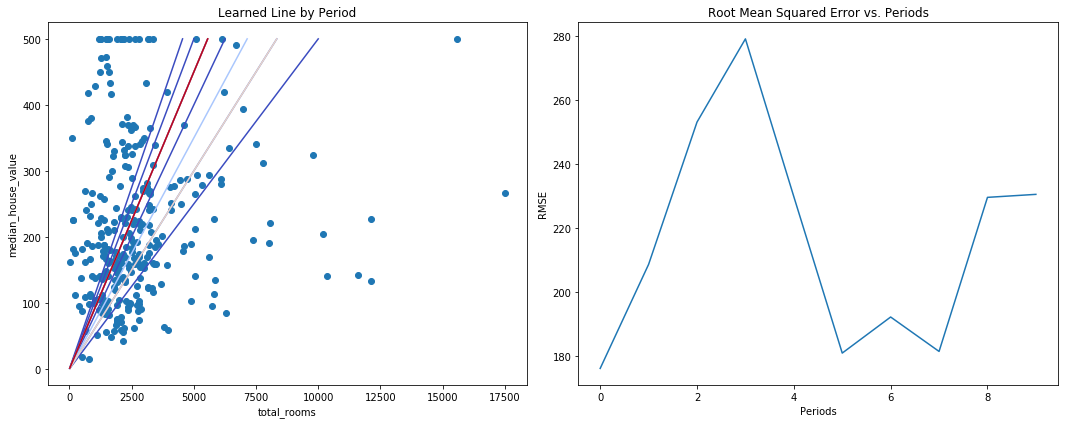

In [60]:
train_model(
    learning_rate=0.001,
    steps = 100,
    batch_size=1
)

Training model...
RMSE (on training data):
period 00 : 175.87
period 01 : 187.56
period 02 : 182.90
period 03 : 182.66
period 04 : 183.66
period 05 : 186.55
period 06 : 189.73
period 07 : 193.29
period 08 : 188.96
period 09 : 188.22
Model training finished


,predictions,targets
count,17000.0,17000.0
mean,174.5,207.3
std,143.9,116.0
min,0.1,15.0
25%,96.5,119.4
50%,140.4,180.4
75%,208.0,265.0
max,2503.8,500.0


Final RMSE (on training data): 188.22


,predictions,targets
0,337.6,66.9
1,283.1,80.1
2,489.1,85.7
3,159.5,73.4
4,594.9,65.5
...,...,...
16995,106.9,111.4
16996,142.9,79.0
16997,107.0,103.6
16998,160.8,85.8


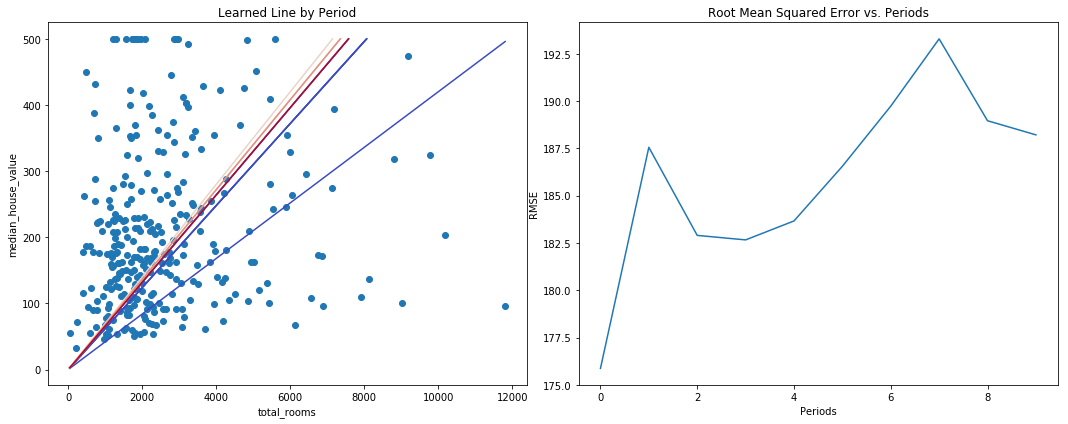

In [95]:
train_model(
    learning_rate=0.0002,
    steps=500,
    batch_size=5
)

尝试其他特征：

Training model...
RMSE (on training data):
period 00 : 234.06
period 01 : 230.60
period 02 : 227.20
period 03 : 223.85
period 04 : 220.48
period 05 : 217.19
period 06 : 213.87
period 07 : 210.73
period 08 : 207.54
period 09 : 204.27
Model training finished


,predictions,targets
count,17000.0,17000.0
mean,40.1,207.3
std,18.6,116.0
min,7.1,15.0
25%,27.2,119.4
50%,36.8,180.4
75%,48.7,265.0
max,148.4,500.0


Final RMSE (on training data): 204.27


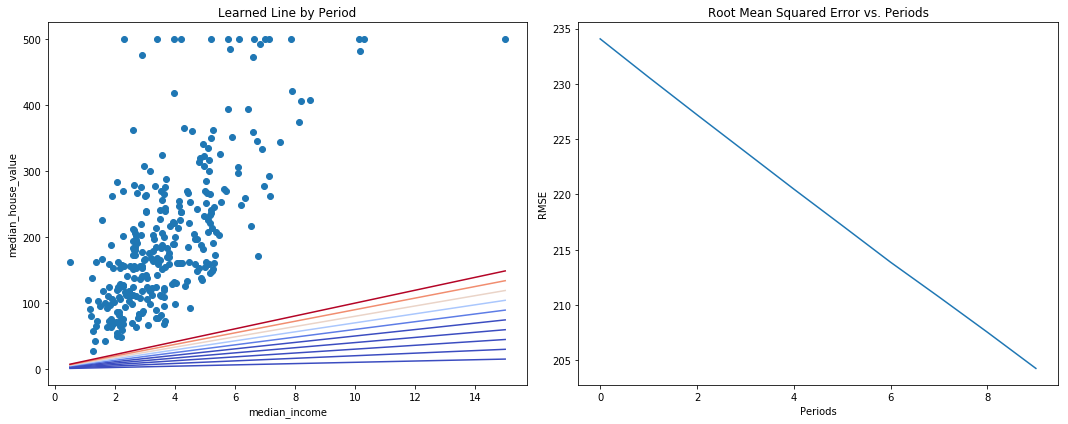

In [67]:
train_model(
    learning_rate=0.002,
    steps=1000,
    batch_size=16,
    input_feature="median_income"
)

尝试合成特征

`total_rooms` 和 `population` 特征都会统计指定街区的相关总计数据

但是，如果一个街区比另一个街区的人口更密集，会怎么样？我们可以创建一个合成特征（即 total_rooms 与 population 的比例）来探索街区人口密度与房屋价值中位数之间的关系。

In [86]:
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]

Training model...
RMSE (on training data):
period 00 : 214.26
period 01 : 193.46
period 02 : 174.86
period 03 : 160.03
period 04 : 151.37
period 05 : 146.29
period 06 : 144.87
period 07 : 145.12
period 08 : 145.08
period 09 : 148.40
Model training finished


,predictions,targets
count,17000.0,17000.0
mean,199.4,207.3
std,91.8,116.0
min,45.4,15.0
25%,163.4,119.4
50%,196.3,180.4
75%,224.3,265.0
max,4378.2,500.0


Final RMSE (on training data): 148.40


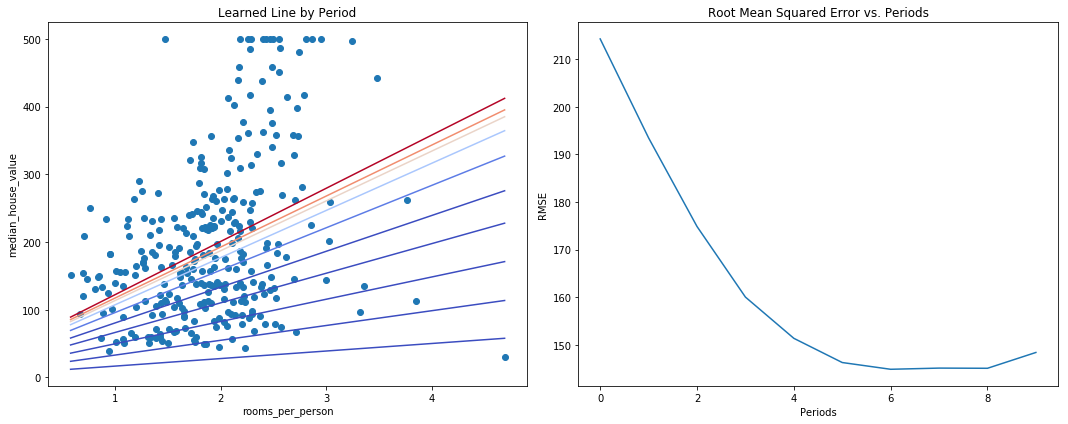

In [79]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)

截取离群值

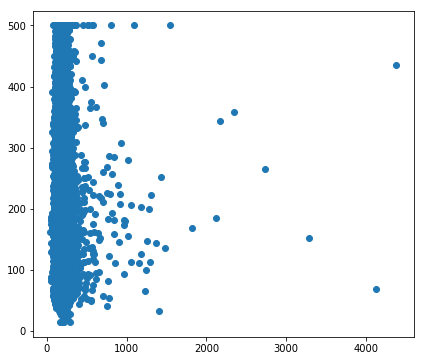

In [80]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

 校准数据显示，大多数散点与一条线对齐。这条线几乎是垂直的，我们稍后再讲解。现在，我们重点关注偏离这条线的点。我们注意到这些点的数量相对较少。

如果我们绘制 `rooms_per_person` 的直方图，则会发现我们的输入数据中有少量离群值：

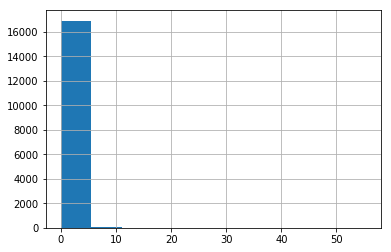

In [87]:
_ = california_housing_dataframe["rooms_per_person"].hist()

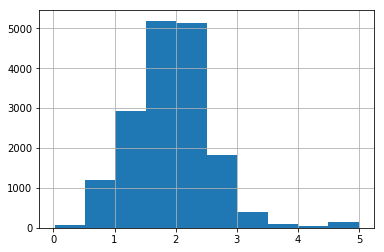

In [88]:
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["rooms_per_person"].apply(lambda x:min(x, 5))
_ = california_housing_dataframe["rooms_per_person"].hist()

为了验证截取是否有效，我们再训练一次模型，并再次输出校准数据

Training model...
RMSE (on training data):
period 00 : 214.31
period 01 : 192.43
period 02 : 172.30
period 03 : 155.04
period 04 : 140.85
period 05 : 133.09
period 06 : 129.66
period 07 : 128.52
period 08 : 128.09
period 09 : 127.12
Model training finished


,predictions,targets
count,17000.0,17000.0
mean,193.9,207.3
std,51.4,116.0
min,43.2,15.0
25%,161.1,119.4
50%,194.0,180.4
75%,221.9,265.0
max,433.7,500.0


Final RMSE (on training data): 127.12


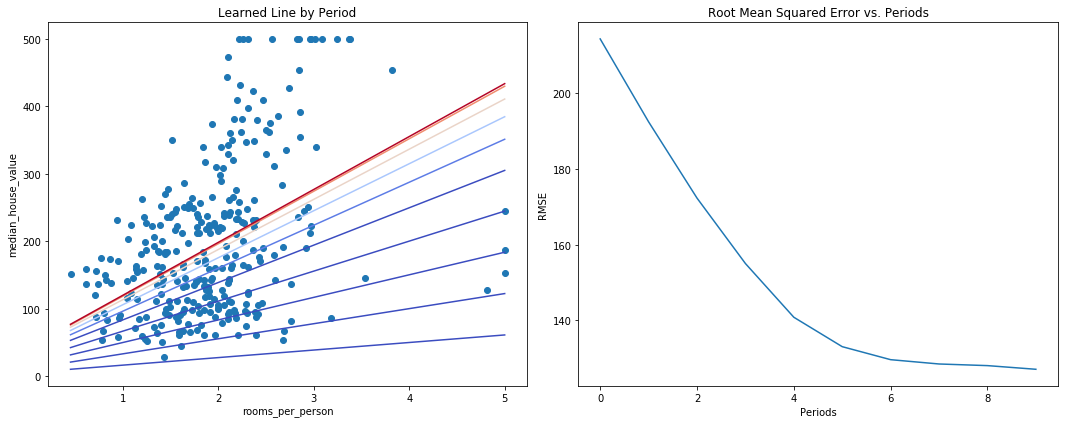

In [92]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

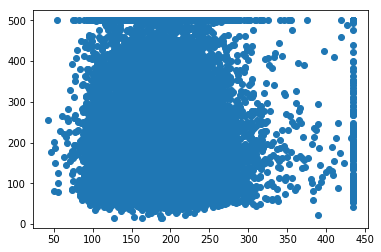

In [93]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])